<a href="https://colab.research.google.com/github/Alexander1718/UIDAI-HACKATHON/blob/main/03_risk_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd
from glob import glob
from collections import defaultdict


In [ ]:
os.makedirs("data", exist_ok=True)

for z in [f for f in os.listdir() if f.endswith(".zip")]:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("data")


In [ ]:
KEYS = ['state', 'district', 'pincode']

def aggregate_large_csvs(folder, value_columns):
    agg = defaultdict(lambda: defaultdict(float))
    csv_files = glob(folder + "/**/*.csv", recursive=True)

    for file in csv_files:
        for chunk in pd.read_csv(file, chunksize=100_000):
            chunk.columns = chunk.columns.str.lower()
            chunk = chunk.dropna(subset=KEYS)

            for _, row in chunk.iterrows():
                key = tuple(row[k] for k in KEYS)
                for col in value_columns:
                    agg[key][col] += row.get(col, 0)

    records = []
    for key, vals in agg.items():
        rec = dict(zip(KEYS, key))
        rec.update(vals)
        records.append(rec)

    return pd.DataFrame(records)


In [ ]:
biometric_df = aggregate_large_csvs(
    "data/api_data_aadhar_biometric",
    ['bio_age_5_17']
)

demographic_df = aggregate_large_csvs(
    "data/api_data_aadhar_demographic",
    ['demo_age_5_17', 'demo_age_17_', 'age_18_greater']
).rename(columns={'age_18_greater':'age_18_plus_demo'})

enrolment_df = aggregate_large_csvs(
    "data/api_data_aadhar_enrolment",
    ['age_5_17', 'age_18_greater']
).rename(columns={'age_18_greater':'age_18_plus_enrol'})


In [ ]:
master_df = biometric_df.merge(
    demographic_df, on=KEYS
).merge(
    enrolment_df, on=KEYS
)

master_df['age_18_greater'] = master_df['age_18_plus_demo']

master_df['service_dependency'] = (
    master_df['demo_age_5_17'] + master_df['demo_age_17_']
) / (master_df['age_18_greater'] + 1)

master_df['service_fragility'] = (
    master_df['bio_age_5_17']
) / (master_df['demo_age_5_17'] + 1)

master_df['demographic_sensitivity'] = (
    master_df['age_5_17']
) / (master_df['age_18_greater'] + 1)

master_df['ASRI'] = (
    master_df['service_dependency'] *
    master_df['service_fragility'] *
    master_df['demographic_sensitivity']
)


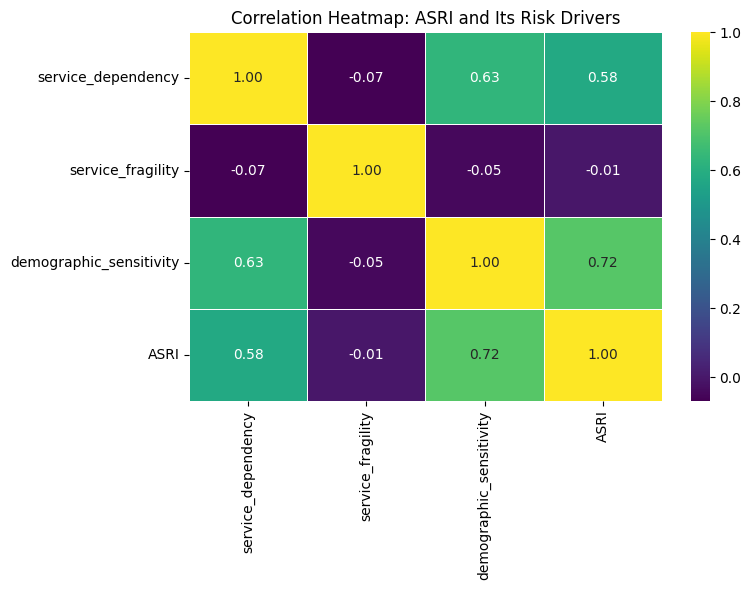

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

driver_cols = [
    'service_dependency',
    'service_fragility',
    'demographic_sensitivity',
    'ASRI'
]

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_df[driver_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5
)

plt.title("Correlation Heatmap: ASRI and Its Risk Drivers")
plt.tight_layout()
plt.show()


In [ ]:
# Percentile-based risk classification
master_df['ASRI_percentile'] = master_df['ASRI'].rank(pct=True)

master_df['risk_category'] = pd.cut(
    master_df['ASRI_percentile'],
    bins=[0, 0.5, 0.8, 0.95, 1.0],
    labels=['Low', 'Moderate', 'High', 'Critical']
)

master_df['risk_category'].value_counts()


,count
risk_category,
Low,14113
Moderate,8467
High,4234
Critical,1412


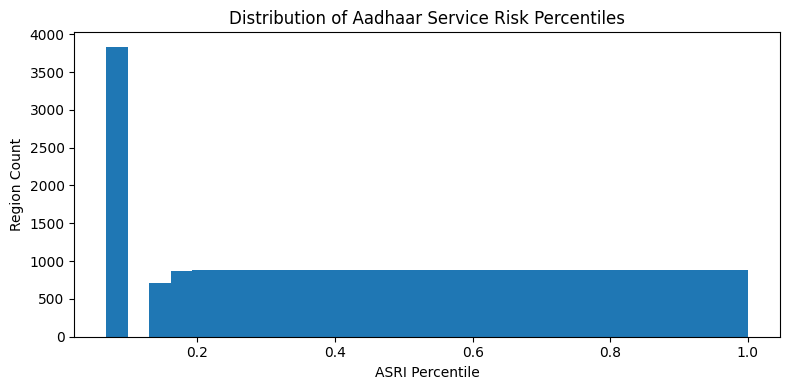

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(
    master_df['ASRI_percentile'],
    bins=30,
    color="#1f77b4"
)

plt.xlabel("ASRI Percentile")
plt.ylabel("Region Count")
plt.title("Distribution of Aadhaar Service Risk Percentiles")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3700037810.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_driver_means = master_df.groupby('risk_category')[


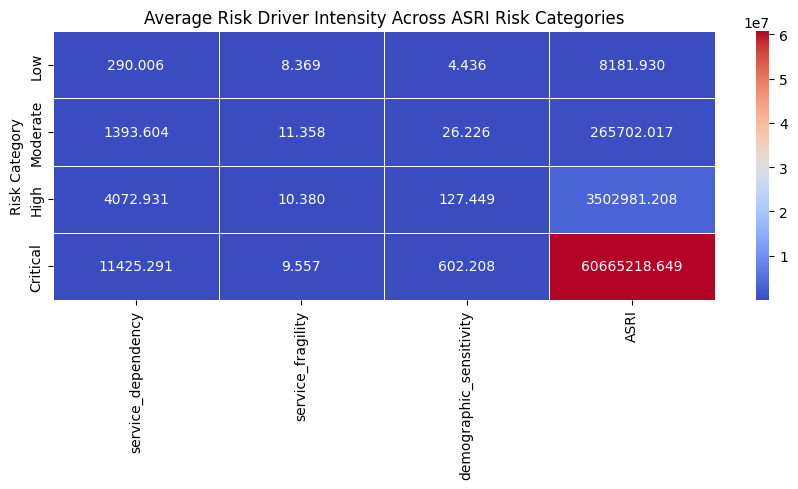

In [ ]:
risk_driver_means = master_df.groupby('risk_category')[
    ['service_dependency', 'service_fragility', 'demographic_sensitivity', 'ASRI']
].mean()

plt.figure(figsize=(9, 5))
sns.heatmap(
    risk_driver_means,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Average Risk Driver Intensity Across ASRI Risk Categories")
plt.ylabel("Risk Category")
plt.tight_layout()
plt.show()


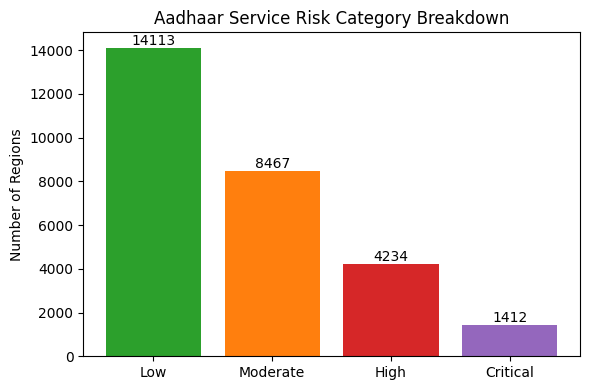

In [ ]:
risk_counts = master_df['risk_category'].value_counts()

colors = ["#2ca02c", "#ff7f0e", "#d62728", "#9467bd"]

plt.figure(figsize=(6, 4))
bars = plt.bar(
    risk_counts.index.astype(str),
    risk_counts.values,
    color=colors
)

plt.ylabel("Number of Regions")
plt.title("Aadhaar Service Risk Category Breakdown")

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


In [ ]:
service_critical_zones = master_df[
    master_df['risk_category'] == 'Critical'
]

len(service_critical_zones)


1412

In [ ]:
service_critical_zones[['state','district','pincode','ASRI']] \
    .sort_values('ASRI', ascending=False) \
    .head(10)


,state,district,pincode,ASRI
16676,Uttar Pradesh,Aligarh,202001,2.675547e+09
4914,Uttar Pradesh,Moradabad,244001,2.368554e+09
16953,Uttar Pradesh,Meerut,250002,1.336826e+09
16991,Uttar Pradesh,Rampur,244901,1.275605e+09
1822,Uttar Pradesh,Shahjahanpur,242001,1.260125e+09
4778,Uttar Pradesh,Firozabad,283203,1.184351e+09
6512,Uttar Pradesh,Saharanpur,247001,1.178778e+09
14115,Uttar Pradesh,Unnao,209801,1.076243e+09
16728,Uttar Pradesh,Bahraich,271865,8.181024e+08
17044,Uttar Pradesh,Varanasi,221001,8.019301e+08


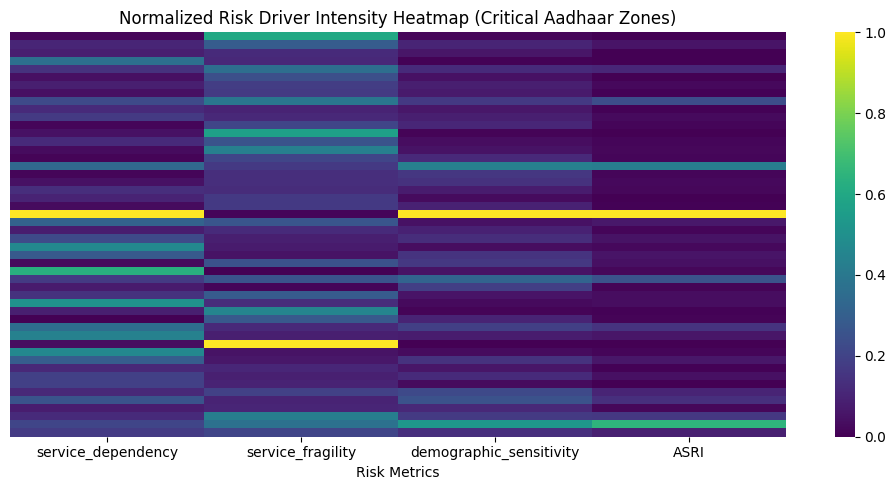

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    'service_dependency',
    'service_fragility',
    'demographic_sensitivity',
    'ASRI'
]

critical_sample = service_critical_zones[cols].sample(
    min(50, len(service_critical_zones)),
    random_state=42
)

# Normalize column-wise
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(
    scaler.fit_transform(critical_sample),
    columns=cols
)

plt.figure(figsize=(10, 5))
sns.heatmap(
    normalized_data,
    cmap="viridis",      # clean, professional, readable
    cbar=True,
    yticklabels=False
)

plt.title("Normalized Risk Driver Intensity Heatmap (Critical Aadhaar Zones)")
plt.xlabel("Risk Metrics")
plt.tight_layout()
plt.show()


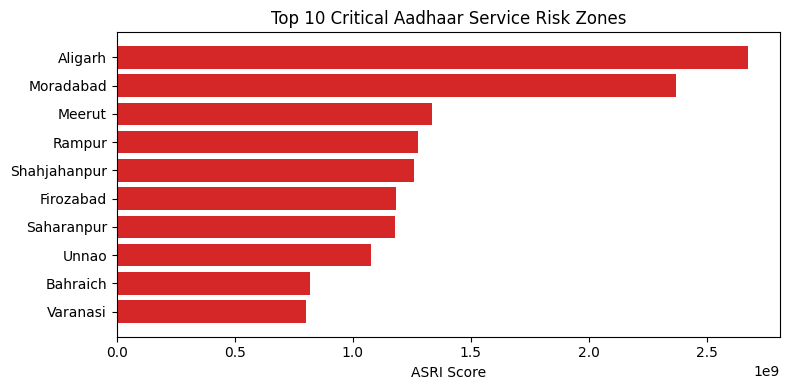

In [ ]:
top_critical = service_critical_zones \
    .sort_values("ASRI", ascending=False) \
    .head(10)

plt.figure(figsize=(8, 4))
plt.barh(
    top_critical['district'],
    top_critical['ASRI'],
    color="#d62728"
)

plt.xlabel("ASRI Score")
plt.title("Top 10 Critical Aadhaar Service Risk Zones")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


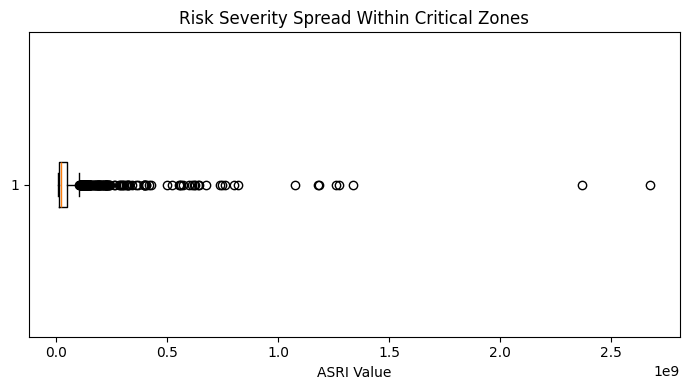

In [ ]:
plt.figure(figsize=(7, 4))
plt.boxplot(
    service_critical_zones['ASRI'],
    vert=False
)

plt.xlabel("ASRI Value")
plt.title("Risk Severity Spread Within Critical Zones")
plt.tight_layout()
plt.show()


In [ ]:
enrollment_quality_risk = master_df[
    (master_df['bio_age_5_17'] == 0) &
    (master_df['demo_age_5_17'] > 100)
]

len(enrollment_quality_risk)


0

In [ ]:
enrollment_quality_risk[['state','district','pincode']] \
    .head(10)


,state,district,pincode


In [ ]:
child_heavy_misfit_zones = master_df[
    (master_df['age_5_17'] /
     (master_df['age_5_17'] + master_df['age_18_greater'])) > 0.7
]

len(child_heavy_misfit_zones)


24651

In [ ]:
child_heavy_misfit_zones[['state','district','pincode']] \
    .head(10)


,state,district,pincode
0,Haryana,Yamuna Nagar,135002
1,Haryana,Yamunanagar,135001
2,Himachal Pradesh,Bilaspur,174004
4,Himachal Pradesh,Bilaspur,174013
7,Himachal Pradesh,Bilaspur,174027
11,Himachal Pradesh,Chamba,176312
16,Himachal Pradesh,Hamirpur,177001
17,Himachal Pradesh,Hamirpur,177023
18,Himachal Pradesh,Hamirpur,177038
20,Himachal Pradesh,Kangra,176022


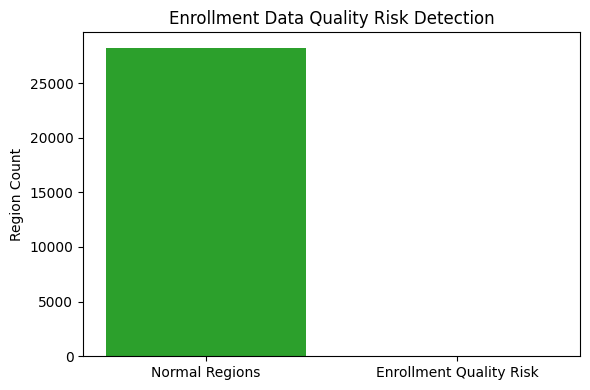

In [ ]:
labels = ['Normal Regions', 'Enrollment Quality Risk']
values = [
    len(master_df) - len(enrollment_quality_risk),
    len(enrollment_quality_risk)
]

colors = ["#2ca02c", "#ff7f0e"]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors)

plt.ylabel("Region Count")
plt.title("Enrollment Data Quality Risk Detection")
plt.tight_layout()
plt.show()



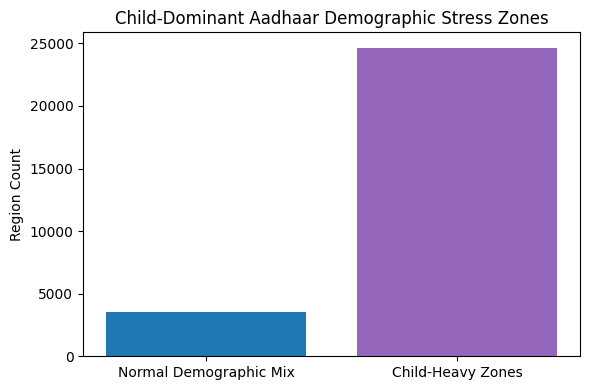

In [ ]:
labels = ['Normal Demographic Mix', 'Child-Heavy Zones']
values = [
    len(master_df) - len(child_heavy_misfit_zones),
    len(child_heavy_misfit_zones)
]

colors = ["#1f77b4", "#9467bd"]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors)

plt.ylabel("Region Count")
plt.title("Child-Dominant Aadhaar Demographic Stress Zones")
plt.tight_layout()
plt.show()


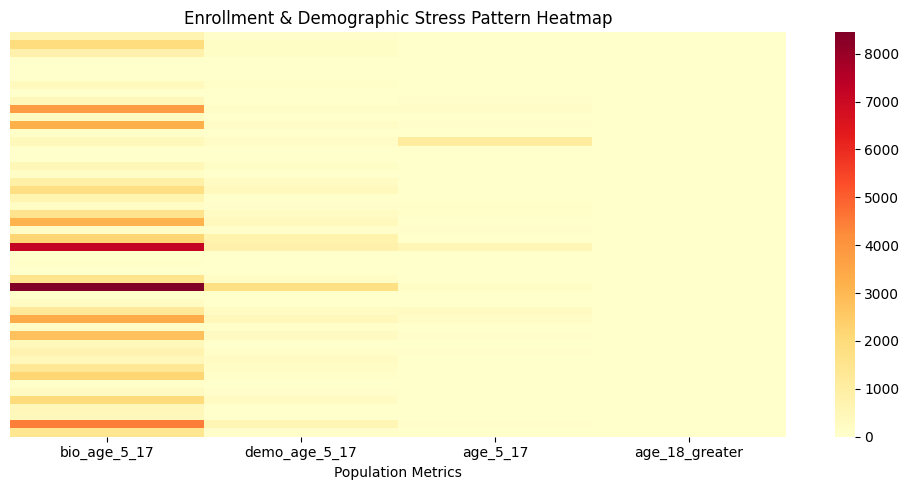

In [ ]:
quality_cols = [
    'bio_age_5_17',
    'demo_age_5_17',
    'age_5_17',
    'age_18_greater'
]

stress_sample = master_df[quality_cols].sample(
    min(50, len(master_df)),
    random_state=42
)

plt.figure(figsize=(10, 5))
sns.heatmap(
    stress_sample,
    cmap="YlOrRd",
    yticklabels=False
)

plt.title("Enrollment & Demographic Stress Pattern Heatmap")
plt.xlabel("Population Metrics")
plt.tight_layout()
plt.show()
